In [2]:
from pathlib import Path
import numpy as np
import pandas_profiling
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json

import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt 





Using TensorFlow backend.


In [3]:

url_no2 = "https://services8.arcgis.com/gtmasQsdfwbDAQSQ/arcgis/rest/services/mes_idf_horaire_no2/FeatureServer/0/query?where=1%3D1&outFields=nom_poll,valeur,unite,date_debut,date_fin,x,y&outSR=4326&f=json"

url_pm25 = "https://services8.arcgis.com/gtmasQsdfwbDAQSQ/arcgis/rest/services/mes_idf_horaire_pm25/FeatureServer/0/query?where=1%3D1&outFields=nom_poll,valeur,unite,date_debut,date_fin,x,y&outSR=4326&f=json"

url_o3 = "https://services8.arcgis.com/gtmasQsdfwbDAQSQ/arcgis/rest/services/mes_idf_journalier_o3/FeatureServer/0/query?where=1%3D1&outFields=nom_poll,valeur,unite,date_debut,date_fin,x,y&outSR=4326&f=json"

url_pm10 = "https://services8.arcgis.com/gtmasQsdfwbDAQSQ/arcgis/rest/services/mes_idf_horaire_pm10/FeatureServer/0/query?where=1%3D1&outFields=nom_poll,valeur,unite,date_debut,date_fin,x,y&outSR=4326&f=json"


In [4]:
def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

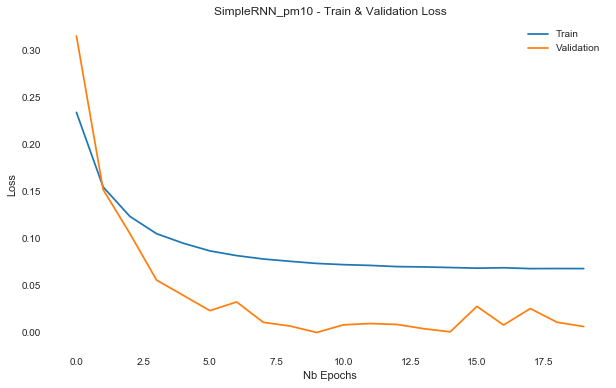

Minimum validation loss of 0.00037874653935432434 reached at epoch 9


In [23]:
df_pm10 = json_normalize(requests.get(url_pm10).json()["features"])
pd.set_option('display.max_rows', None)

df_pm10= df_pm10.rename(columns = {'attributes.nom_poll':'poll', 'attributes.valeur':'valeur', 'attributes.unite':'unite',
                          'attributes.date_debut':'debut', 'attributes.date_fin':'fin', 'geometry.x':'x', 'geometry.y':'y'})

measure = df_pm10.to_json(orient ='index')

df_pm10 = df_pm10.drop(columns=['poll', 'unite', 'fin', 'attributes.x', 'attributes.y', 'x', 'y'])
df_pm10 = df_pm10.set_index('debut')

train_pm10 = df_pm10.query('debut < 1509004800000')
valid_pm10 = df_pm10.query('debut >= 1509004800000 and debut < 1511222400000')
test_pm10 = df_pm10.query('debut >= 1511222400000')

# Save column names and indices to use when storing as csv
cols_pm10 = train_pm10.columns
train_idx_pm10 = train_pm10.index
valid_idx_pm10 = valid_pm10.index
test_idx_pm10 = test_pm10.index

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train_pm10 = scaler.fit_transform(train_pm10)
valid_pm10 = scaler.transform(valid_pm10)
test_pm10 = scaler.transform(test_pm10)

train_pm10 = pd.DataFrame(train_pm10, columns=cols_pm10, index=train_idx_pm10)
valid_pm10 = pd.DataFrame(valid_pm10, columns=cols_pm10, index=valid_idx_pm10)
test_pm10 = pd.DataFrame(test_pm10, columns=cols_pm10, index=test_idx_pm10)

train_pm10.to_csv('./train_pm10.csv')
valid_pm10.to_csv('./valid_pm10.csv')
test_pm10.to_csv('./test_pm10.csv')

train_pm10 = pd.read_csv('./train_pm10.csv', header=0, index_col=0).values.astype('float32')
valid_pm10 = pd.read_csv('./valid_pm10.csv', header=0, index_col=0).values.astype('float32')
test_pm10 = pd.read_csv('./test_pm10.csv', header=0, index_col=0).values.astype('float32')

n_lag = 8

train_data_gen_pm10 = TimeseriesGenerator(train_pm10, train_pm10, length=n_lag, sampling_rate=1, stride=1, batch_size = 5)
valid_data_gen_pm10 = TimeseriesGenerator(train_pm10, train_pm10, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)
test_data_gen_pm10 = TimeseriesGenerator(test_pm10, test_pm10, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)


simple_rnn_pm10 = Sequential()
simple_rnn_pm10.add(SimpleRNN(4, input_shape=(n_lag, 1)))
simple_rnn_pm10.add(Dense(1))
simple_rnn_pm10.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='./simple_rnn_weights_pm10.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("./simple_rnn_pm10.json", "w") as m:
    m.write(simple_rnn_pm10.to_json())

simple_rnn_history_pm10 = simple_rnn_pm10.fit_generator(train_data_gen_pm10
                                              , epochs=100
                                              , validation_data=valid_data_gen_pm10
                                              , verbose=0
                                              , callbacks=[checkpointer, earlystopper])
plot_loss(simple_rnn_history_pm10, 'SimpleRNN_pm10 - Train & Validation Loss')

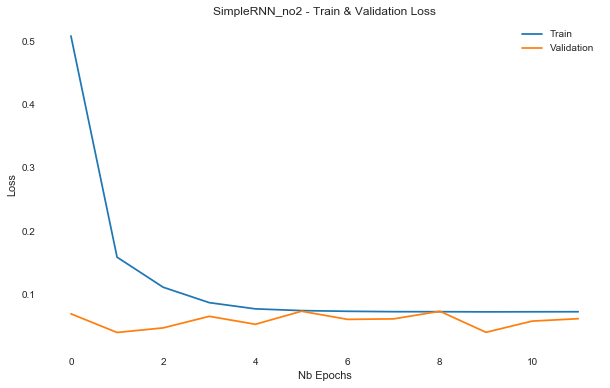

Minimum validation loss of 0.0389954149723053 reached at epoch 1


In [25]:
df_no2 = json_normalize(requests.get(url_no2).json()["features"])
pd.set_option('display.max_rows', None)

df_no2= df_no2.rename(columns = {'attributes.nom_poll':'poll', 'attributes.valeur':'valeur', 'attributes.unite':'unite',
                          'attributes.date_debut':'debut', 'attributes.date_fin':'fin', 'geometry.x':'x', 'geometry.y':'y'})

measure = df_no2.to_json(orient ='index')

df_no2 = df_no2.drop(columns=['poll', 'unite', 'fin', 'attributes.x', 'attributes.y', 'x', 'y'])
df_no2 = df_no2.set_index('debut')

train_no2 = df_no2.query('debut < 1509004800000')
valid_no2 = df_no2.query('debut >= 1509004800000 and debut < 1511222400000')
test_no2 = df_no2.query('debut >= 1511222400000')

# Save column names and indices to use when storing as csv
cols_no2 = train_no2.columns
train_idx_no2 = train_no2.index
valid_idx_no2 = valid_no2.index
test_idx_no2 = test_no2.index

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train_no2 = scaler.fit_transform(train_no2)
valid_no2 = scaler.transform(valid_no2)
test_no2 = scaler.transform(test_no2)

train_no2 = pd.DataFrame(train_no2, columns=cols_no2, index=train_idx_no2)
valid_no2 = pd.DataFrame(valid_no2, columns=cols_no2, index=valid_idx_no2)
test_no2 = pd.DataFrame(test_no2, columns=cols_no2, index=test_idx_no2)

train_no2.to_csv('./train_no2.csv')
valid_no2.to_csv('./valid_no2.csv')
test_no2.to_csv('./test_no2.csv')

train_no2 = pd.read_csv('./train_no2.csv', header=0, index_col=0).values.astype('float32')
valid_no2 = pd.read_csv('./valid_no2.csv', header=0, index_col=0).values.astype('float32')
test_no2 = pd.read_csv('./test_no2.csv', header=0, index_col=0).values.astype('float32')

n_lag = 8

train_data_gen_no2 = TimeseriesGenerator(train_no2, train_no2, length=n_lag, sampling_rate=1, stride=1, batch_size = 5)
valid_data_gen_no2 = TimeseriesGenerator(train_no2, train_no2, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)
test_data_gen_no2 = TimeseriesGenerator(test_no2, test_no2, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)


simple_rnn_no2 = Sequential()
simple_rnn_no2.add(SimpleRNN(4, input_shape=(n_lag, 1)))
simple_rnn_no2.add(Dense(1))
simple_rnn_no2.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='./simple_rnn_weights_no2.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("./simple_rnn_no2.json", "w") as m:
    m.write(simple_rnn_no2.to_json())

simple_rnn_history_no2 = simple_rnn_no2.fit_generator(train_data_gen_no2
                                              , epochs=100
                                              , validation_data=valid_data_gen_no2
                                              , verbose=0
                                              , callbacks=[checkpointer, earlystopper])
plot_loss(simple_rnn_history_no2, 'SimpleRNN_no2 - Train & Validation Loss')

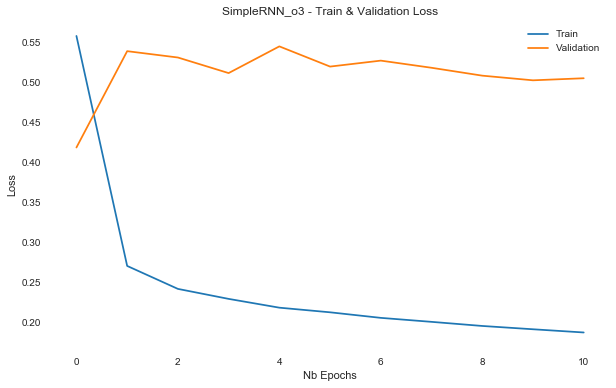

Minimum validation loss of 0.4181985557079315 reached at epoch 0


In [7]:
df_o3 = json_normalize(requests.get(url_o3).json()["features"])
pd.set_option('display.max_rows', None)

df_o3= df_o3.rename(columns = {'attributes.nom_poll':'poll', 'attributes.valeur':'valeur', 'attributes.unite':'unite',
                          'attributes.date_debut':'debut', 'attributes.date_fin':'fin', 'geometry.x':'x', 'geometry.y':'y'})

measure = df_o3.to_json(orient ='index')

df_o3 = df_o3.drop(columns=['poll', 'unite', 'fin', 'attributes.x', 'attributes.y', 'x', 'y'])
df_o3 = df_o3.set_index('debut')

train_o3 = df_o3.query('debut < 1509004800000')
valid_o3 = df_o3.query('debut >= 1509004800000 and debut < 1511222400000')
test_o3 = df_o3.query('debut >= 1511222400000')

# Save column names and indices to use when storing as csv
cols_o3 = train_o3.columns
train_idx_o3 = train_o3.index
valid_idx_o3 = valid_o3.index
test_idx_o3 = test_o3.index

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train_o3 = scaler.fit_transform(train_o3)
valid_o3 = scaler.transform(valid_o3)
test_o3 = scaler.transform(test_o3)

train_o3 = pd.DataFrame(train_o3, columns=cols_o3, index=train_idx_o3)
valid_o3 = pd.DataFrame(valid_o3, columns=cols_o3, index=valid_idx_o3)
test_o3 = pd.DataFrame(test_o3, columns=cols_o3, index=test_idx_o3)

train_o3.to_csv('./train_o3.csv')
valid_o3.to_csv('./valid_o3.csv')
test_o3.to_csv('./test_o3.csv')

train_o3 = pd.read_csv('./train_o3.csv', header=0, index_col=0).values.astype('float32')
valid_o3 = pd.read_csv('./valid_o3.csv', header=0, index_col=0).values.astype('float32')
test_o3 = pd.read_csv('./test_o3.csv', header=0, index_col=0).values.astype('float32')

n_lag = 8

train_data_gen_o3 = TimeseriesGenerator(train_o3, train_o3, length=n_lag, sampling_rate=1, stride=1, batch_size = 3)
valid_data_gen_o3 = TimeseriesGenerator(train_o3, train_o3, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)
test_data_gen_o3 = TimeseriesGenerator(test_o3, test_o3, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)


simple_rnn_o3 = Sequential()
simple_rnn_o3.add(SimpleRNN(4, input_shape=(n_lag, 1)))
simple_rnn_o3.add(Dense(1))
simple_rnn_o3.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='./simple_rnn_weights_o3.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("./simple_rnn_o3.json", "w") as m:
    m.write(simple_rnn_o3.to_json())

simple_rnn_history_o3 = simple_rnn_o3.fit_generator(train_data_gen_o3
                                              , epochs=100
                                              , validation_data=valid_data_gen_o3
                                              , verbose=0
                                              , callbacks=[checkpointer, earlystopper])
plot_loss(simple_rnn_history_o3, 'SimpleRNN_o3 - Train & Validation Loss')

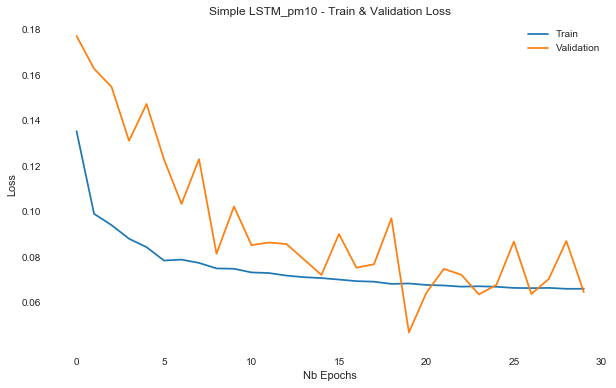

Minimum validation loss of 0.046785082668066025 reached at epoch 19


In [11]:
simple_lstm_pm10 = Sequential()
simple_lstm_pm10.add(LSTM(4, input_shape=(n_lag, 1)))
simple_lstm_pm10.add(Dense(1))
simple_lstm_pm10.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='./simple_lstm_weights_pm10.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("./simple_lstm_pm10.json", "w") as m:
    m.write(simple_lstm_pm10.to_json())

simple_lstm_history_pm10 = simple_lstm_pm10.fit_generator(train_data_gen_pm10
                                                , epochs=100
                                                , validation_data=valid_data_gen_pm10
                                                , verbose=0
                                                , callbacks=[checkpointer, earlystopper])
plot_loss(simple_lstm_history_pm10, 'Simple LSTM_pm10 - Train & Validation Loss')

In [38]:
train_data_gen_o3[0]

(array([[[0.98275864],
         [0.9137931 ],
         [0.98275864],
         [0.94827586],
         [0.7241379 ],
         [0.86206895],
         [0.7413793 ],
         [0.7413793 ]],
 
        [[0.9137931 ],
         [0.98275864],
         [0.94827586],
         [0.7241379 ],
         [0.86206895],
         [0.7413793 ],
         [0.7413793 ],
         [0.79310346]],
 
        [[0.98275864],
         [0.94827586],
         [0.7241379 ],
         [0.86206895],
         [0.7413793 ],
         [0.7413793 ],
         [0.79310346],
         [0.87931037]]], dtype=float32), array([[0.79310346],
        [0.87931037],
        [0.70689654]], dtype=float32))

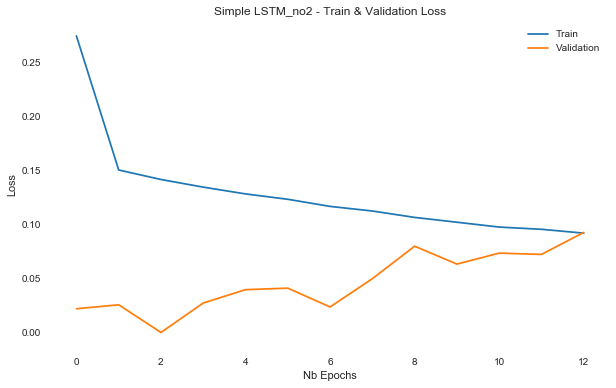

Minimum validation loss of 0.0003090500831604004 reached at epoch 2


In [33]:
simple_lstm_no2 = Sequential()
simple_lstm_no2.add(LSTM(4, input_shape=(n_lag, 1)))
simple_lstm_no2.add(Dense(1))
simple_lstm_no2.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='./simple_lstm_weights_no2.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("./simple_lstm_no2.json", "w") as m:
    m.write(simple_lstm_no2.to_json())

simple_lstm_history_no2 = simple_lstm_no2.fit_generator(train_data_gen_no2
                                                , epochs=100
                                                , validation_data=valid_data_gen_no2
                                                , verbose=0
                                                , callbacks=[checkpointer, earlystopper])
plot_loss(simple_lstm_history_no2, 'Simple LSTM_no2 - Train & Validation Loss')

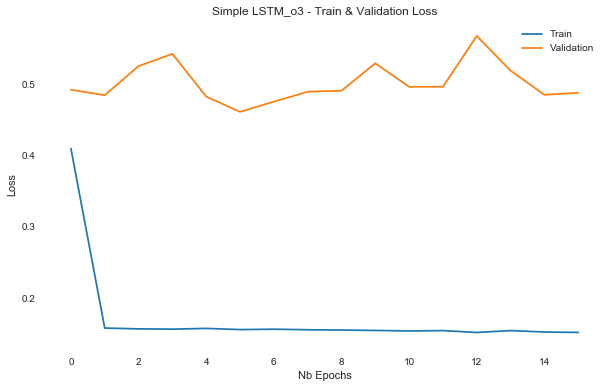

Minimum validation loss of 0.4609738886356354 reached at epoch 5


In [49]:
simple_lstm_o3 = Sequential()
simple_lstm_o3.add(LSTM(4, input_shape=(n_lag, 1)))
simple_lstm_o3.add(Dense(1))
simple_lstm_o3.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='./simple_lstm_weights_o3.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("./simple_lstm_o3.json", "w") as m:
    m.write(simple_lstm_o3.to_json())

simple_lstm_history_o3 = simple_lstm_o3.fit_generator(train_data_gen_o3
                                                , epochs=50
                                                , validation_data=valid_data_gen_o3
                                                , verbose=0
                                                , callbacks=[checkpointer, earlystopper])
plot_loss(simple_lstm_history_o3, 'Simple LSTM_o3 - Train & Validation Loss')

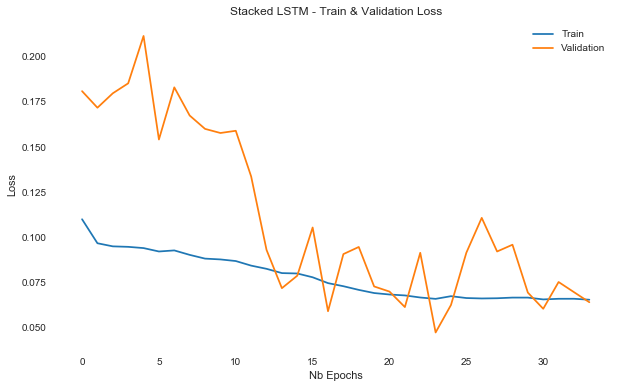

Minimum validation loss of 0.047359649091959 reached at epoch 23


In [11]:
stacked_lstm_pm10 = Sequential()
stacked_lstm_pm10.add(LSTM(16, input_shape=(n_lag, 1), return_sequences=True))
stacked_lstm_pm10.add(LSTM(8, return_sequences=True))
stacked_lstm_pm10.add(LSTM(4))
stacked_lstm_pm10.add(Dense(1))
stacked_lstm_pm10.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='./stacked_lstm_weights_pm10.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("./stacked_lstm_pm10.json", "w") as m:
    m.write(stacked_lstm_pm10.to_json())

stacked_lstm_history_pm10 = stacked_lstm_pm10.fit_generator(train_data_gen_pm10
                                                  , epochs=100
                                                  , validation_data=valid_data_gen_pm10
                                                  , verbose=0
                                                  , callbacks=[checkpointer, earlystopper])
plot_loss(stacked_lstm_history_pm10, 'Stacked LSTM_pm10 - Train & Validation Loss')

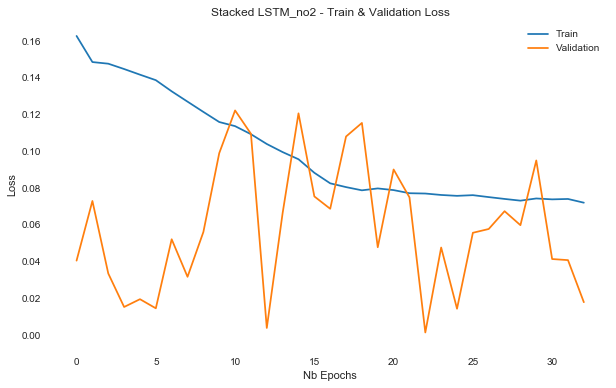

Minimum validation loss of 0.0014595985412597656 reached at epoch 22


In [47]:
stacked_lstm_no2 = Sequential()
stacked_lstm_no2.add(LSTM(16, input_shape=(n_lag, 1), return_sequences=True))
stacked_lstm_no2.add(LSTM(8, return_sequences=True))
stacked_lstm_no2.add(LSTM(4))
stacked_lstm_no2.add(Dense(1))
stacked_lstm_no2.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='./stacked_lstm_weights_no2.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("./stacked_lstm_no2.json", "w") as m:
    m.write(stacked_lstm_no2.to_json())

stacked_lstm_history_no2 = stacked_lstm_no2.fit_generator(train_data_gen_no2
                                                  , epochs=100
                                                  , validation_data=valid_data_gen_no2
                                                  , verbose=0
                                                  , callbacks=[checkpointer, earlystopper])
plot_loss(stacked_lstm_history_no2, 'Stacked LSTM_no2 - Train & Validation Loss')

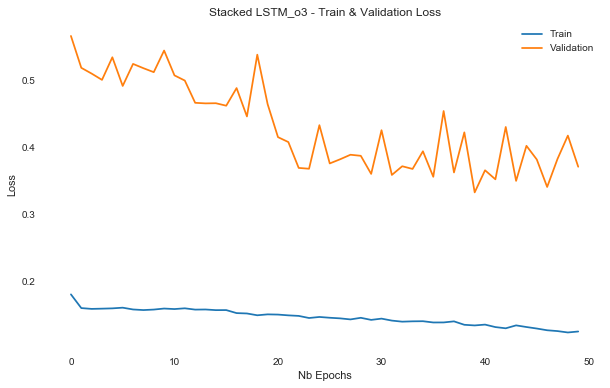

Minimum validation loss of 0.3330921530723572 reached at epoch 39


In [48]:
stacked_lstm_o3 = Sequential()
stacked_lstm_o3.add(LSTM(16, input_shape=(n_lag, 1), return_sequences=True))
stacked_lstm_o3.add(LSTM(8, return_sequences=True))
stacked_lstm_o3.add(LSTM(4))
stacked_lstm_o3.add(Dense(1))
stacked_lstm_o3.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='./stacked_lstm_weights_o3.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("./stacked_lstm_o3.json", "w") as m:
    m.write(stacked_lstm_o3.to_json())

stacked_lstm_history_o3 = stacked_lstm_o3.fit_generator(train_data_gen_o3
                                                  , epochs=100
                                                  , validation_data=valid_data_gen_o3
                                                  , verbose=0
                                                  , callbacks=[checkpointer, earlystopper])
plot_loss(stacked_lstm_history_o3, 'Stacked LSTM_o3 - Train & Validation Loss')